# EMA-LABELLING-DL_EXPERIMENTS_DIFFERENT-THRESOLDS (TRANSFORMER_ 6 classes)

In [3]:
'''Import libraries'''
import mat73
import numpy as np
import seaborn as sns
from numpy import where
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import sklearn
from numpy import argmax
from sklearn.metrics import (roc_auc_score,accuracy_score,confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,balanced_accuracy_score)
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv1D, Dense, Input,Flatten,Dropout,MaxPooling1D,GlobalAveragePooling1D,InputLayer,GaussianNoise
from tensorflow.keras.regularizers import l1
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [4]:
'''Usefull fuctions'''

'''Load data'''
def load_EMA_data(data='PREPROCESED_CAPTURE24_ALL_DATA_EMA_LABELED_THRES_0_AP_V3.mat',as_float32=True):
    fileName = data
    mat = mat73.loadmat(fileName)#load v73 matlab files
    data_X = mat['data']['data_AP']
    label_y = mat['data']['label_EMA']
    label_AP = mat['data']['label_AP']
    idLOSO = mat['data']['id']
    if as_float32:
        data_X = data_X.astype(np.float32)
    return (data_X,label_y,idLOSO,label_AP)

'''Training-test_data selection'''
def train_val_test(idx):
    trainset= [1101, 1102, 1103, 1105, 1106, 1107, 1108, 1109, 1112, 1113, 1114, 1115,
     1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128,
     1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140,
     1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1154, 1157,
     1159, 1160, 1161, 1162, 1163, 1164, 1165, 1167, 1168, 1169, 1171, 1172,
     1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184,
     1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198,
     1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210,
     1211, 1213, 1214, 1217, 1218, 1219, 1222, 1268, 1277, 2101, 2103, 2104,
     2105, 2106, 2107, 2109, 2110, 2111, 2113, 2114, 2117, 2118, 2119, 2120,
     2121, 2122, 2123, 2124, 2125, 2126, 2128, 2129, 2132, 2133, 2135, 2136,
     2137, 2138, 2139, 2140, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150,
     2152, 2153, 2154, 2155, 2156, 2158, 2159, 2160, 2161, 2162, 2163, 2164,
     2165, 2166, 2168, 2169, 2175, 2177, 2178, 2179, 2180, 2181, 2182, 2183,
     2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195,
     2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207,
     2208, 2209, 2210, 2211, 2212, 2213, 2215, 2216, 2217, 2218, 2219, 2220,
     2221, 2222, 2223, 2224, 2228, 2259, 2260, 2262, 2264, 3101, 3102, 3103,
     3104, 3105, 3106, 3107, 3108, 3110, 3111, 3112, 3113, 3114, 3115, 3116,
     3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129,
     3132, 3133, 3134, 3136, 3138, 3139, 3141, 3142, 3143, 3144, 3145, 3146,
     3147, 3148, 3150, 3151, 3152, 3153, 3154, 3156, 3157, 3158, 3159, 3160,
     3161, 3162, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3173, 3174]
    valset = [3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186,
     3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3197, 3198, 3199, 3200,
     3201, 3203, 3204, 3206, 3207, 3208, 3216, 3217, 3218, 3221, 3229, 3241,
     3248, 3249, 3250, 3254, 3255, 4101, 4102, 4103, 4104, 4106, 4107, 4108,
     4109, 4110, 4112, 4113, 4115, 4116, 4118, 4119, 4122, 4123, 4124, 4125,
     4127, 4128, 4129, 4130, 4131, 4132, 4134, 4135, 4136, 4137, 4138, 4139,
     4141, 4142, 4143, 4144, 4145, 4146, 4147, 4149, 4150, 4151, 4153, 4154,
     4155, 4157, 4159, 4160, 4161, 4162, 4163, 4190, 4451, 4452, 4453, 4455,
     4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467,
     4468, 4469, 4470, 4471, 4472, 4473, 4475, 4476, 4477, 4478, 4480, 4484,
     4485, 4486, 4487, 4488, 4494, 4495, 4496, 4497, 4498, 4499, 4506, 4507]
    testset = [1104, 1110, 1212, 1220, 1221, 1223, 1224, 1227, 1229, 1232, 1233, 1234,
     1236, 1237, 1238, 1239, 1240, 1241, 1242, 1244, 1247, 1249, 1250, 1251,
     1252, 1253, 1254, 1256, 1257, 1258, 1260, 1261, 1263, 1264, 1265, 1266,
     1267, 1269, 1271, 1272, 1273, 1276, 1279, 1280, 1281, 1282, 2108, 2170,
     2171, 2173, 2174, 2225, 2226, 2227, 2229, 2230, 2231, 2232, 2233, 2234,
     2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246,
     2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2257, 2258, 2265,
     2266, 2267, 2268, 2269, 2270, 3137, 3172, 3205, 3209, 3210, 3211, 3212,
     3213, 3219, 3220, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3230, 3231,
     3234, 3235, 3237, 3238, 3239, 3242, 3243, 3244, 3245, 3246, 3247, 3251,
     3252, 3253, 3256, 4114, 4140, 4164, 4165, 4166, 4167, 4168, 4171, 4174,
     4175, 4178, 4179, 4181, 4182, 4183, 4184, 4185, 4187, 4188, 4189, 4192,
     4193, 4195, 4481, 4482, 4500, 4501, 4502, 4503, 4504, 4505, 4508, 4509,
     4510, 4511, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522,
     4523, 4524, 4525, 4526, 4527, 4528]

    trainInd,valInd,testInd = [],[],[]
    for subject in trainset:
        ind = where(idx == subject)
        trainInd.append(ind[0])
    trainInd = np.concatenate(trainInd,axis=0)
    for subject in valset:
        ind = where(idx == subject)
        valInd.append(ind[0])
    valInd = np.concatenate(valInd,axis=0)
    for subject in testset:
        ind = where(idx == subject)
        testInd.append(ind[0])
    testInd = np.concatenate(testInd,axis=0)
    return trainInd, valInd, testInd

def multilabel_selector(index_array, selected_ids):
    res = []
    for currentindex in selected_ids:
        ind = np.where(index_array == currentindex)
        res.append(ind[0])
    selectecIndexes = np.concatenate(res,axis=0)
    selectecIndexes = np.sort(selectecIndexes)#sort list to preserve idx order
    return selectecIndexes

def clf_multi_to_predict_proba(y_predict_train):
    y_predict_train=np.array(y_predict_train)
    y_predict_train=y_predict_train[:,:,1]#get column 1(positive prediction)
    y_predict_train=np.transpose(y_predict_train)#swap axis
    return y_predict_train

def metricsOnSubsets_multiclass(model,X_train3D, y_train, X_train3D_val, y_train_val, dataTest, labelTest):
    '''Evaluate Performance'''
    print("---------------------------------------------------------------")
    print("---------------------------------------------------------------")
    print('\nTRAIN')
    print(X_train3D.shape)
    y_predict_train = model.predict(X_train3D,batch_size=batchSize)
    results_train=performance_evaluation_multiclass(y_train,y_predict_train,color="Blues")
    '''Test performance'''
    print("---------------------------------------------------------------")
    print("---------------------------------------------------------------")
    print('\nVALIDATION')
    print(X_train3D_val.shape)
    y_predict_val = model.predict(X_train3D_val,batch_size=batchSize)
    results_val = performance_evaluation_multiclass(y_train_val,y_predict_val,color="Oranges")
    print("---------------------------------------------------------------")
    print("---------------------------------------------------------------")
    print('\nTEST')
    print(dataTest.shape)
    y_predict_test = model.predict(dataTest,batch_size=batchSize)
    results_test = performance_evaluation_multiclass(labelTest,y_predict_test,color="Blues")
    results_metrics= {'Train':results_train , 'Validation': results_val, 'Test': results_test}
    return results_metrics

def plotNomalizedConfMatrix(y_test, y_pred, labels=['0','1','2','3','4','6','8'],color='Blues'):
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm, index = labels, columns = labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm_df, annot=True,cmap=color,fmt='.0%',cbar=False,annot_kws={'size': 12})
    plt.ylabel('True label',fontsize=12)
    plt.xlabel('Prediction',fontsize=12)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12,rotation=0)
    plt.show()

def performance_evaluation_multiclass(y_test,y_predict_prob,color='Blues', cf_plot=False):
    multiclass_AUC=roc_auc_score(y_test, y_predict_prob, multi_class='ovr')#Ejecute before argmax
    y_pred=np.argmax(y_predict_prob, axis=1)
    y_test=np.argmax(y_test, axis=1)
    balanced_accuracy=balanced_accuracy_score(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    metricas=precision_recall_fscore_support(y_test, y_pred, average='macro')
    precision, recall=metricas[0],metricas[1]
    f1=f1_score(y_test, y_pred, average='macro')
    print('Balanced_accuracy_score: '+ str(round(100*(balanced_accuracy),2))+"%"+"\n")
    print('Precision: ', precision)
    print('Recall', recall)
    print('Fscore', f1)
    print('Multiclass_AUC: '+ str(multiclass_AUC))
    results=[balanced_accuracy,precision,recall,f1,multiclass_AUC]
    if cf_plot:
        try:
            plotNomalizedConfMatrix(y_test, y_pred,labels=['Sitting','Standing','Walking','Jogging','Sports','Cycling'],color=color)
        except:
            print("PLOT ERROR")
    return results

def printLabel_distribution(y, plot_title="Class distribution", label_map=None):
    df = pd.DataFrame(y)
    count_classes = df[0].value_counts().sort_index()
    # If a label map is provided, apply it to the index (class labels)
    if label_map:
        count_classes.index = count_classes.index.map(label_map)
    count_classes.plot(kind='bar', rot=0)
    plt.title(plot_title)
    plt.xlabel("Physical activity")
    plt.ylabel("Number of observations")
    plt.show()

def trainModel(X_train, y_train, X_val, y_val):
    tf.keras.backend.clear_session()
    optimizer =tf.keras.optimizers.Adam(learning_rate=learningRate)

    flat_y=argmax(y_train, axis=1)
    class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(flat_y),y = flat_y)
    class_weight_dict = dict(enumerate(class_weights))
    sample_weights = np.array([class_weight_dict[class_id] for class_id in flat_y])

    '''Train the model'''
    model=tranformerModel2(window_length=60,num_classes=6, patch_size=20, projection_dim=128,
                      num_heads=8, num_blocks=3, trafo_drop=0.3, mlp_drop=0.3, mlp_units=60 )
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'],weighted_metrics=['accuracy'])
    stop_early=EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',restore_best_weights=True) #default patience=8
    reduce_lr = ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, mode="min", verbose=1 )
    history = model.fit(X_train, y_train, epochs=nEpochs, validation_data=(X_val, y_val),
                        callbacks=[stop_early,reduce_lr], verbose=1,sample_weight=sample_weights)# class_weight=to_set_weights
    val_accuracy = model.evaluate(X_val, y_val, batch_size=batchSize, verbose=0)
    model.summary()
    return model, val_accuracy, history

def to_categorical(y, num_classes=None):
    y = np.array(y, dtype='int')
    if not num_classes:
        num_classes = np.max(y) + 1
    return np.eye(num_classes)[y]

def underSampling(X, y1, target_value=0, n_samples=250000):
    #underSamples a specific class
    flat_y=argmax(y1, axis=1)#transform to hard-label
    target_indices = np.where(flat_y == target_value)[0]# Find indices where the data matches the target
    other_indices = np.where(flat_y != target_value)[0]# Find indices where the data does not match the target
    #Check if there are enough instances of the target value to reduce
    if len(target_indices) <= n_samples:
        print('Not enough instances to undersample')
        return X, y1   #If not enough instances return original arrays
    # Randomly select n_samples from the target value instances while keeping the order
    selected_target_indices = np.random.choice(target_indices, size=n_samples, replace=False)
    us_X = np.concatenate([X[selected_target_indices], X[other_indices]])#select data
    us_y1 = np.concatenate([y1[selected_target_indices], y1[other_indices]])
    return us_X, us_y1

def tranformerModel2(window_length,num_classes, patch_size=4,projection_dim=40,
                     num_heads=4,num_blocks=1,trafo_drop=0.3,mlp_drop=0.5, mlp_units=40 ):
    time_steps=int(window_length/patch_size)
    inputs = Input(shape=(window_length, 3))
    #Patch input with CNN
    patches = Conv1D(filters=projection_dim, kernel_size=patch_size,strides=patch_size,padding="same")(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(time_steps, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim,num_heads,num_blocks, dropout_rate=trafo_drop)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    outputs = MLP(projection_dim, mlp_units, dropout_rate=mlp_drop)(representation)
    # Softmax classification
    outputs = Dense(num_classes, activation="softmax")(outputs)
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
#VIT adapted to inertial signals
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches=196, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

class MLP(tf.keras.layers.Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

class Block(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, x]) #encoded_patches
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        y = tf.keras.layers.Add()([x3, x2])
        return y

class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=12, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Create a [batch_size, projection_dim] tensor.
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        y = self.dropout(x)
        return y

### Holdout repeatedTest

In [6]:
def holdout_repeatedTest(X_train, y_train, X_val, y_val, X_test, y_test, repeated_tests=3):
    results_train=np.zeros((repeated_tests,5))
    results_val=np.zeros((repeated_tests,5))
    results_test=np.zeros((repeated_tests,5))
    '''Main loop'''
    for i in range(repeated_tests):
        print("---------------------------------------------------------------")
        print("---------------------------------------------------------------")
        print(i)
        model, val_metrics,history = trainModel(X_train, y_train, X_val, y_val)
        print(f'Accuracy/Loss : {val_metrics} --- batch : {batchSize}, learning rate : {learningRate}')
        results_metrics=metricsOnSubsets_multiclass(model, X_train, y_train, X_val, y_val, X_test, y_test)
        results_train[i]=results_metrics['Train']
        results_val[i]=results_metrics['Validation']
        results_test[i]=results_metrics['Test']

    mainresults={'Train': results_train, 'Validation': results_val, 'Test': results_test}
    return mainresults,model,history

In [7]:
import pandas as pd
def printsummary_Results(results_np_matrix,print_mean=True):
    df = pd.DataFrame(results_np_matrix,columns=['Accuracy', 'Precision','Recall','Fscore','AUC',])
    summary_mean=df.mean()
    summary_std=df.std()
    if print_mean==True:
        res=summary_mean
    else:
        res=summary_std
    df=res.to_frame().T
    df = df.reset_index(drop=True)
    return df

### DATA SELECTION AND SPLITING

In [8]:
def format_data(X,y,idLOSO, selected_ids=[0,1,2,3,4,6,8]):
    y_mask=multilabel_selector(index_array=y, selected_ids=selected_ids)#Select specific classes
    X, y , idLOSO = X[y_mask,:], y[y_mask],idLOSO[y_mask] #Apply mask
    #Reassign label number before one-hot encoding
    y[y == 4] = 3 #Running
    y[y == 6] = 4 #Sports
    y[y == 8] = 5 #Cycling
    printLabel_distribution(y)
    y = to_categorical(y)#one-hot encoding
    trainIdx, valIdx,testIdx = train_val_test(idLOSO)
    X_train, y_train,loso_train = X[trainIdx,:,:], y[trainIdx,:], idLOSO[trainIdx]
    X_val, y_val,loso_val= X[valIdx,:,:], y[valIdx,:], idLOSO[valIdx]
    X_test, y_test,loso_test = X[testIdx,:,:], y[testIdx,:], idLOSO[testIdx]
    print("Train set unique participants: ", len(np.unique(loso_train)))
    print("Val set unique participants: ", len(np.unique(loso_val)))
    print("Test set unique participants: ", len(np.unique(loso_test)))
    print("X_train_shape: ", X_train.shape)
    print("X_val_shape: ", X_val.shape)
    print("X_test_shape: ", X_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

## TEST AND EVALUATION

In [9]:
import gc

In [10]:
def run_train_and_test(data):
    '''Load and define training, and test data'''
    X,y,idLOSO,_= load_EMA_data(data)#
    X_train, y_train, X_val, y_val, X_test, y_test=format_data(X,y,idLOSO,selected_ids=[0,1,2,4,6,8])
    del X,y,idLOSO
    gc.collect()
    '''RandomUnderSampler on TRAIN'''
    X_train, y_train = underSampling(X_train, y_train, target_value=0, n_samples=300000)
    printLabel_distribution(argmax(y_train, axis=1), plot_title="Undersampled data distribution (Train set)", label_map = {0: 'Sitting', 1: 'Standing', 2: 'Walking',3: 'Running', 4: 'Sports', 5: 'Cycling'} )
    '''Holdout Repeated test'''
    main_results_repeated,model,history =holdout_repeatedTest(X_train, y_train, X_val, y_val, X_test, y_test,repeated_tests=3)
    '''Summary of Results'''
    print('Main results (average of 3 iterations)')
    df1=printsummary_Results(main_results_repeated['Train'],print_mean=True)
    df1['Data'] = 'Train'
    df2=printsummary_Results(main_results_repeated['Test'],print_mean=True)
    df2['Data'] = 'Test'
    dfRes=pd.concat([df1, df2])
    dfRes = dfRes[['Data'] + [col for col in dfRes.columns if col != 'Data']]
    dfRes = dfRes.style.hide(axis='index')
    return dfRes

# RUN EXPERIMENTS:

In [11]:
learningRate=0.0000519
windowSize=60
batchSize=512
nClasses=6
nEpochs=120

In [12]:
#Train and evaluate using 0% Threshold dataset
dfRes_0=run_train_and_test('PREPROCESED_RAW_ALL_DATA_FREE_LIVING_EMA_LABELED_THRES_0_AP_V3.mat')

In [13]:
#Train and evaluate using 50% Threshold dataset
dfRes_50=run_train_and_test('PREPROCESED_RAW_ALL_DATA_FREE_LIVING_EMA_LABELED_THRES_0.5_AP_V3.mat')

In [14]:
#Train and evaluate using 75% Threshold dataset
dfRes_75=run_train_and_test('PREPROCESED_RAW_ALL_DATA_FREE_LIVING_EMA_LABELED_THRES_0.75_AP_V3.mat')

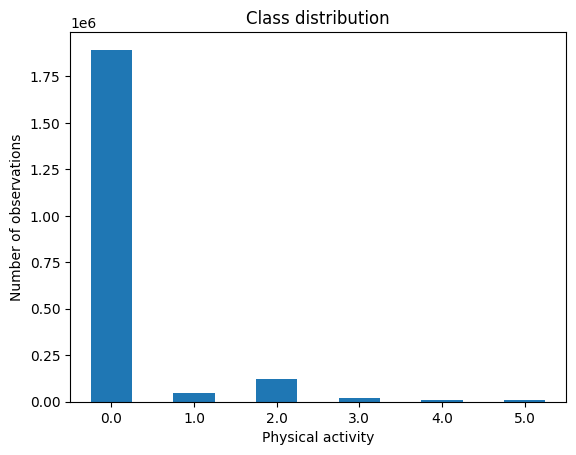

Train set unique participants:  272
Val set unique participants:  131
Test set unique participants:  171
X_train_shape:  (1004760, 60, 3)
X_val_shape:  (466040, 60, 3)
X_test_shape:  (615120, 60, 3)


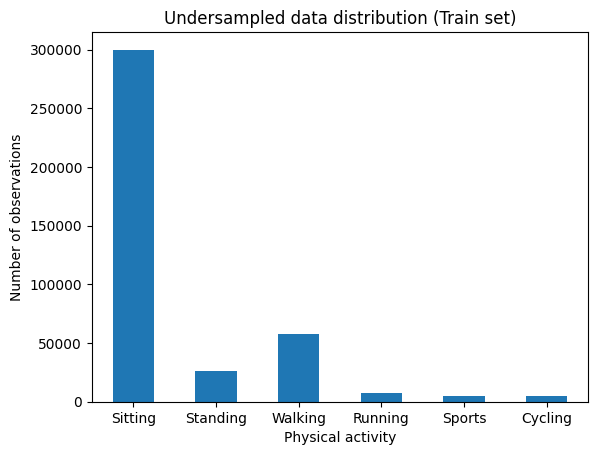

---------------------------------------------------------------
---------------------------------------------------------------
0
Epoch 1/120
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 191s 13ms/step - accuracy: 0.8476 - loss: 0.9215 - weighted_accuracy: 0.6242 - val_accuracy: 0.9331 - val_loss: 0.2450 - val_weighted_accuracy: 0.9331 - learning_rate: 5.1975e-05
Epoch 2/120
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 152s 12ms/step - accuracy: 0.9331 - loss: 0.6192 - weighted_accuracy: 0.7518 - val_accuracy: 0.9719 - val_loss: 0.1277 - val_weighted_accuracy: 0.9719 - learning_rate: 5.1975e-05
Epoch 3/120
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 157s 13ms/step - accuracy: 0.9422 - loss: 0.5719 - weighted_accuracy: 0.7751 - val_accuracy: 0.9744 - val_loss: 0.1235 - val_weighted_accuracy: 0.9744 - learning_rate: 5.1975e-05
Epoch 4/120
12551/12551 ━━━━━━━━━━━━━━━━━━━━ 153s 12ms/step - accuracy: 0.9453 - loss: 0.5510 - weighted_accuracy: 0.7882 - val_accuracy: 0.9774 - val_loss: 0.1128 - val_weighted_accuracy: 0.9774 - 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3, 128)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 4, 128)         │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 4, 128)         │     1,782,016 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_3 (MLP)                     │ (None, 60)             │        24,252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           366 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,494,400 (20.96 MB)

 Trainable params: 1,831,466 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,662,934 (13.97 MB)

Accuracy/Loss : [0.10377553105354309, 0.9753648042678833, 0.9753648042678833, 0.9753648042678833] --- batch : 512, learning rate : 5.1975e-05
---------------------------------------------------------------
---------------------------------------------------------------

TRAIN
(401620, 60, 3)
785/785 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
[[297327   2052    202     24    185    210]
 [   105  25678     83      4    180     50]
 [    44   1353  52494    946   2798     65]
 [     6     89   2312   5197    194      2]
 [     7     85    977    583   3065    183]
 [    55     78      4      1    177   4805]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    300000
           1       0.88      0.98      0.93     26100
           2       0.94      0.91      0.92     57700
           3       0.77      0.67      0.71      7800
           4       0.46      0.63      0.53      4900
           5       0.90      0.94      0.92      5120

    accuracy   

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3, 128)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 4, 128)         │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 4, 128)         │     1,782,016 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_3 (MLP)                     │ (None, 60)             │        24,252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           366 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,494,400 (20.96 MB)

 Trainable params: 1,831,466 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,662,934 (13.97 MB)

Accuracy/Loss : [0.1026962399482727, 0.9772122502326965, 0.9772122502326965, 0.9772122502326965] --- batch : 512, learning rate : 5.1975e-05
---------------------------------------------------------------
---------------------------------------------------------------

TRAIN
(401620, 60, 3)
785/785 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
[[297779   1618    168     25    224    186]
 [   244  25595     80      0    160     21]
 [    48   1404  51288   1055   3864     41]
 [     7    100   2335   5045    312      1]
 [     8    107   1310    761   2465    249]
 [    75    112      4      1    279   4649]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    300000
           1       0.88      0.98      0.93     26100
           2       0.93      0.89      0.91     57700
           3       0.73      0.65      0.69      7800
           4       0.34      0.50      0.40      4900
           5       0.90      0.91      0.91      5120

    accuracy    

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3, 128)         │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 4, 128)         │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 4, 128)         │     1,782,016 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_3 (MLP)                     │ (None, 60)             │        24,252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           366 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,494,400 (20.96 MB)

 Trainable params: 1,831,466 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,662,934 (13.97 MB)

Accuracy/Loss : [0.10033579915761948, 0.9783087372779846, 0.9783087372779846, 0.9783087372779846] --- batch : 512, learning rate : 5.1975e-05
---------------------------------------------------------------
---------------------------------------------------------------

TRAIN
(401620, 60, 3)
785/785 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
[[297674   1791    219     21     83    212]
 [   244  25666     97      0     54     39]
 [    47   1622  53033    999   1923     76]
 [     6    114   2466   5104    107      3]
 [     8    122   1492    831   1926    521]
 [    81    107      9      1     29   4893]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    300000
           1       0.87      0.98      0.92     26100
           2       0.93      0.92      0.92     57700
           3       0.73      0.65      0.69      7800
           4       0.47      0.39      0.43      4900
           5       0.85      0.96      0.90      5120

    accuracy   

In [15]:
#Train and evaluate using 90% Threshold dataset
dfRes_90=run_train_and_test('PREPROCESED_RAW_ALL_DATA_FREE_LIVING_EMA_LABELED_THRES_0.9_AP_V3.mat')

In [16]:
#Results at 0% Threshold
dfRes_0

In [17]:
#Results at 50% Threshold
dfRes_50

In [18]:
#Results at 75% Threshold
dfRes_75

In [19]:
#Results at 90% Threshold
dfRes_90

Data,Accuracy,Precision,Recall,Fscore,AUC
Train,0.829598,0.810208,0.829598,0.816959,0.990248
Test,0.765215,0.705921,0.765215,0.730000,0.975556
